In [1]:
import streamlit as st
import pandas as pd
import numpy as np
import plotly.express as px
import matplotlib.pyplot as plt
%matplotlib inline 

df = pd.pandas.read_csv('data_capstone_dsa2021_2022.csv')

abbrev_to_us_state = {
        'AK': 'Alaska',
        'AL': 'Alabama',
        'AR': 'Arkansas',
        'AS': 'American Samoa',
        'AZ': 'Arizona',
        'CA': 'California',
        'CO': 'Colorado',
        'CT': 'Connecticut',
        'DC': 'District of Columbia',
        'DE': 'Delaware',
        'FL': 'Florida',
        'GA': 'Georgia',
        'GU': 'Guam',
        'HI': 'Hawaii',
        'IA': 'Iowa',
        'ID': 'Idaho',
        'IL': 'Illinois',
        'IN': 'Indiana',
        'KS': 'Kansas',
        'KY': 'Kentucky',
        'LA': 'Louisiana',
        'MA': 'Massachusetts',
        'MD': 'Maryland',
        'ME': 'Maine',
        'MI': 'Michigan',
        'MN': 'Minnesota',
        'MO': 'Missouri',
        'MP': 'Northern Mariana Islands',
        'MS': 'Mississippi',
        'MT': 'Montana',
        'NA': 'Unknown or foreign',
        'NC': 'North Carolina',
        'ND': 'North Dakota',
        'NE': 'Nebraska',
        'NH': 'New Hampshire',
        'NJ': 'New Jersey',
        'NM': 'New Mexico',
        'NV': 'Nevada',
        'NY': 'New York',
        'OH': 'Ohio',
        'OK': 'Oklahoma',
        'OR': 'Oregon',
        'PA': 'Pennsylvania',
        'PR': 'Puerto Rico',
        'RI': 'Rhode Island',
        'SC': 'South Carolina',
        'SD': 'South Dakota',
        'TN': 'Tennessee',
        'TX': 'Texas',
        'UT': 'Utah',
        'VA': 'Virginia',
        'VI': 'Virgin Islands',
        'VT': 'Vermont',
        'WA': 'Washington',
        'WI': 'Wisconsin',
        'WV': 'West Virginia',
        'WY': 'Wyoming'
}

us_state_to_abbrev = dict(map(reversed, abbrev_to_us_state.items()))

us_state_name_list = [state_name.upper() for state_name in list(abbrev_to_us_state.values())]
us_state_abbrev_list = [abbrev.upper() for abbrev in list(abbrev_to_us_state.keys())]

uppercase_us_state_to_abbrev = dict(zip(us_state_name_list, us_state_abbrev_list))

def normalize_state(state_string):
    temp = state_string.replace(".", "")
    temp = temp.upper()
    
    import re
    temp_list = temp.replace("USVI", "US VI")
    temp_list = re.split("[/, ]", temp_list)
    new_list = []
    for word in temp_list:
        if word in us_state_abbrev_list:
            new_list.append(str.upper(abbrev_to_us_state[word]))
        elif word == 'AMERICA':
            new_list.append('-')
        else:
            new_list.append(word)
    temp = str.strip(' '.join(new_list))       

    from fuzzywuzzy import process
    best_match = process.extractOne(temp, us_state_name_list)
    if best_match[1] >= 86:
        return uppercase_us_state_to_abbrev[best_match[0]]
    else:
        return 'NA'

df['state'] = df['state'].apply(normalize_state)

df['all']= np.ones(len(df.index), dtype='int64')

/opt/anaconda3/lib/python3.8/site-packages/fuzzywuzzy/fuzz.py:11: UserWarning: Using slow pure-python SequenceMatcher. Install python-Levenshtein to remove this warning
  warnings.warn('Using slow pure-python SequenceMatcher. Install python-Levenshtein to remove this warning')
2022-01-29 21:30:06.082 WARNING root: Applied processor reduces input query to empty string, all comparisons will have score 0. [Query: '-']
2022-01-29 21:30:08.729 WARNING root: Applied processor reduces input query to empty string, all comparisons will have score 0. [Query: '-']


In [2]:
import geopandas as gpd
from shapely.geometry import Point, Polygon

usa = gpd.read_file('States 21basic/geo_export_b421321d-b4cb-4f18-8a01-4d4c471d7e2e.shp')

df_usa = usa.merge(df, left_on='state_abbr', right_on='state')

abbrev_list= list(df.groupby('state').mean().index)
sum_score_list = ["{0:0.1f}".format(i) for i in list(df.groupby('state').mean()['sum_score'])]
age_list = ["{0:0.1f}".format(i) for i in list(df.groupby('state').mean()['age'])]
abbrev_to_sum_score_dict = dict(zip(abbrev_list,sum_score_list))
abbrev_to_age_dict = dict(zip(abbrev_list,age_list));

list(usa['sub_region'].unique())
# ['Pacific',
#  'Mountain',
#  'New England',
#  'West North Central',
#  'East North Central',
#  'Middle Atlantic',
#  'South Atlantic',
#  'East South Central',
#  'West South Central']



['Pacific',
 'Mountain',
 'New England',
 'West North Central',
 'East North Central',
 'Middle Atlantic',
 'South Atlantic',
 'East South Central',
 'West South Central']

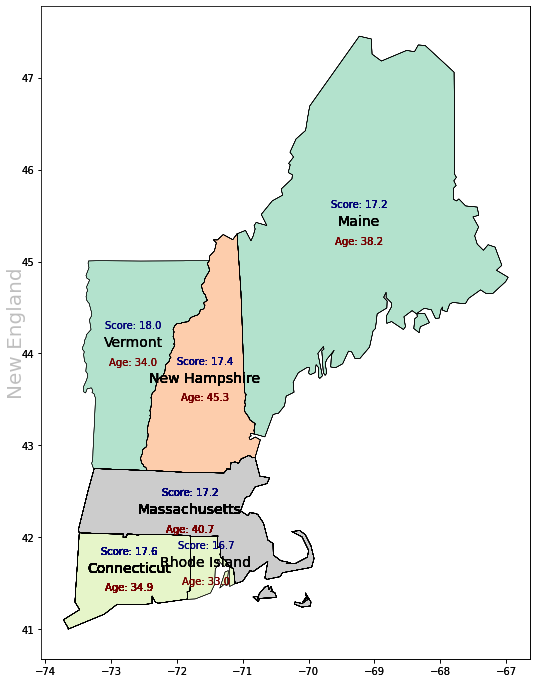

In [16]:
region_selected_string = 'New England'
region_selected_df = df_usa[df_usa['sub_region'] == region_selected_string]
region_selected_df.plot(cmap='Pastel2', figsize=(12, 12))

fig = plt.figure(1, figsize=(8,8)) 
ax = fig.add_subplot()
# Label 1 State Name
region_selected_df.apply(lambda x: ax.annotate(text=x.state_name, xy=x.geometry.centroid.coords[0], ha='center', fontsize=14),axis=1);
# Label 2 Score using longitudinal offset
region_selected_df.apply(
    lambda x: ax.annotate(
        text='Score: ' + str(abbrev_to_sum_score_dict[x.state_abbr]) , 
        xy= (x.geometry.centroid.coords[0][0], x.geometry.centroid.coords[0][1]+.2),
        ha='center', 
        color='#000077', # blue
        fontsize=10),axis=1);
# Label 3 Age using longitudinal Offset 
region_selected_df.apply(
    lambda x: ax.annotate(
        text='Age: ' + str(abbrev_to_age_dict[x.state_abbr]), 
        xy= (x.geometry.centroid.coords[0][0] , x.geometry.centroid.coords[0][1] - 0.2 ),
        ha='center',
        color='#770000', #red
        fontsize=10),axis=1);
region_selected_df.boundary.plot(ax=ax, color='Black', linewidth=.4)
region_selected_df.plot(ax=ax, cmap='Pastel2', figsize=(12, 12))
ax.text(-0.05, 0.5, region_selected_string, transform=ax.transAxes,
        fontsize=20, color='gray', alpha=0.5,
        ha='center', va='center', rotation='90');

In [28]:
df_usa['percent_female']=df_usa['gender'].eq('Female').mul(1)
df_usa['percent_home_computer']=df_usa['home_computer'].eq('Yes').mul(1)
temp = df_usa.dissolve(by='state_name', aggfunc='mean')
temp2 = df_usa[['state_name','state_abbr', 'sub_region']].drop_duplicates()
df_usa_2 = temp.merge(temp2, left_on='state_name', right_on='state_name')
df_usa_2.explore(
    column="sub_region", 
     tooltip=["state_name", "sum_score", "rt_total", "age", 'percent_female', 'percent_home_computer'],
     tiles="CartoDB positron",
     cmap="Accent",
     style_kwds=dict(color="black")
)

In [38]:
temp3= df_usa_2.dissolve(by='sub_region', aggfunc='mean')
temp3.explore(
    column="all", 
     tooltip=["sub_region", "sum_score", "rt_total", "age", 'percent_female', 'percent_home_computer'],
     tiles="CartoDB positron",
     cmap="Accent",
     style_kwds=dict(color="black")
)

/opt/anaconda3/lib/python3.8/site-packages/mapclassify/classifiers.py:891: RuntimeWarning: invalid value encountered in double_scalars
  gadf = 1 - self.adcm / adam
